# 03 - Tokenization and Dataset Creation

This notebook implements tokenization using CodeBERT and creates PyTorch datasets for smart contract vulnerability detection.

**Objectives:**
- Load CodeBERT tokenizer for code tokenization
- Implement tokenization with proper truncation and attention masks
- Create PyTorch Dataset class for vulnerability detection
- Implement data collation and batching
- Create train/validation/test splits
- Save processed datasets for model training

## Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import pickle
from pathlib import Path
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("🚀 Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

🚀 Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: False


## Load and Explore Data

In [3]:
# Load the processed dataset
print("📂 Loading processed dataset...")
data_path = Path('../data/processed/function_dataset.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

📂 Loading processed dataset...
Dataset shape: (16720, 9)

Columns: ['function_name', 'code', 'is_vulnerable', 'vulnerability_category', 'vulnerability_types', 'contract_file', 'function_type', 'code_length', 'num_bugs']

First few rows:


,function_name,code,is_vulnerable,vulnerability_category,vulnerability_types,contract_file,function_type,code_length,num_bugs
0,play_TOD33,function play_TOD33(bytes32 guess) public{\nif...,True,TOD,TOD,buggy_43.sol,function,143,3
1,getReward_TOD33,function getReward_TOD33() payable public{\nwi...,True,TOD,TOD,buggy_43.sol,function,78,4
2,_setMetadata,function _setMetadata(bytes memory metadata) i...,True,TOD,TOD,buggy_43.sol,function,85,4
3,setReward_TOD2,function setReward_TOD2() public payable {\nre...,True,TOD,TOD,buggy_43.sol,function,163,4
4,claimReward_TOD2,function claimReward_TOD2(uint256 submission) ...,True,TOD,TOD,buggy_43.sol,function,162,6


📊 DATASET STATISTICS
Total functions: 16,720
Vulnerable functions: 968
Safe functions: 15,752
Vulnerability rate: 5.8%

Code length statistics:
count    16720.000000
mean       190.270096
std        375.331495
min         51.000000
25%         95.000000
50%        143.000000
75%        179.000000
max       9313.000000
Name: code_length, dtype: float64

Vulnerability distribution by category:
                        Total  Vulnerable   Rate
vulnerability_category                          
Overflow-Underflow       2490         136  0.055
Re-entrancy              2195         126  0.057
TOD                      3523         198  0.056
Timestamp-Dependency     1983         125  0.063
Unchecked-Send           2120         120  0.057
Unhandled-Exceptions     2221         134  0.060
tx.origin                2188         129  0.059


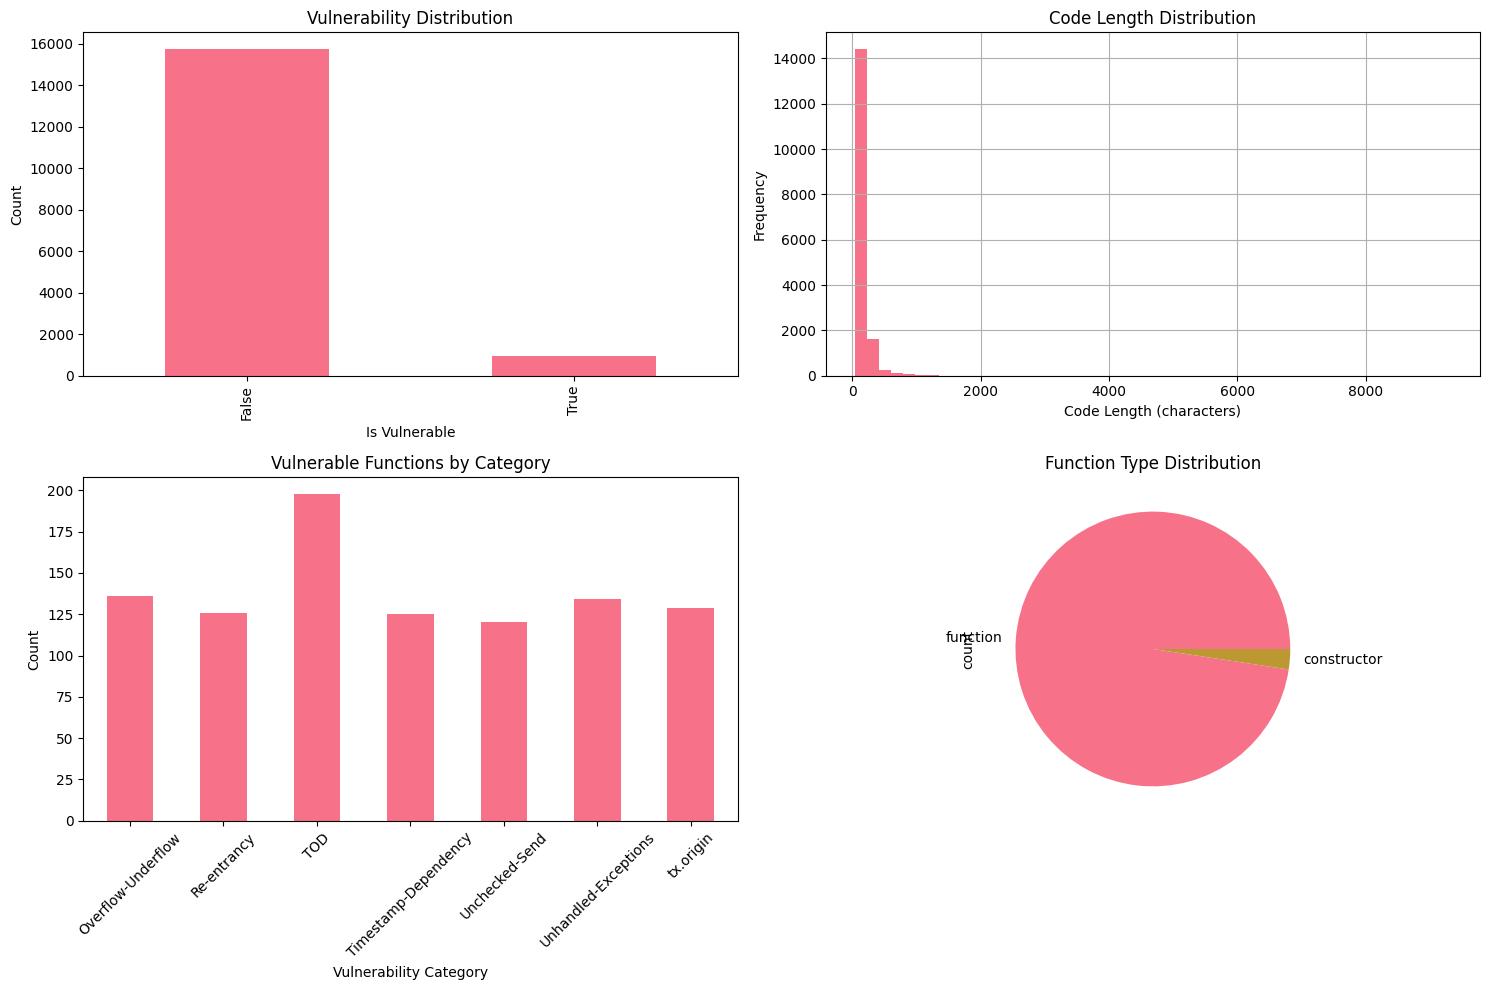

In [4]:
# Analyze dataset statistics
print("📊 DATASET STATISTICS")
print("=" * 40)

print(f"Total functions: {len(df):,}")
print(f"Vulnerable functions: {df['is_vulnerable'].sum():,}")
print(f"Safe functions: {(~df['is_vulnerable']).sum():,}")
print(f"Vulnerability rate: {df['is_vulnerable'].mean():.1%}")

print(f"\nCode length statistics:")
print(df['code_length'].describe())

# Vulnerability distribution by category
print(f"\nVulnerability distribution by category:")
vuln_dist = df.groupby('vulnerability_category').agg({
    'is_vulnerable': ['count', 'sum', 'mean']
}).round(3)
vuln_dist.columns = ['Total', 'Vulnerable', 'Rate']
print(vuln_dist)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vulnerability distribution
df['is_vulnerable'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Vulnerability Distribution')
axes[0,0].set_xlabel('Is Vulnerable')
axes[0,0].set_ylabel('Count')

# Code length distribution
df['code_length'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Code Length Distribution')
axes[0,1].set_xlabel('Code Length (characters)')
axes[0,1].set_ylabel('Frequency')

# Vulnerability by category
vuln_by_cat = df.groupby('vulnerability_category')['is_vulnerable'].sum()
vuln_by_cat.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Vulnerable Functions by Category')
axes[1,0].set_xlabel('Vulnerability Category')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Function type distribution
df['function_type'].value_counts().plot(kind='pie', ax=axes[1,1])
axes[1,1].set_title('Function Type Distribution')

plt.tight_layout()
plt.show()

## Initialize CodeBERT Tokenizer

In [5]:
# Load CodeBERT tokenizer
print("🔤 Loading CodeBERT tokenizer...")
MODEL_NAME = "microsoft/codebert-base"

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    print(f"✅ Successfully loaded tokenizer: {MODEL_NAME}")
    print(f"Vocabulary size: {tokenizer.vocab_size:,}")
    print(f"Max position embeddings: {tokenizer.model_max_length}")
    
    # Test tokenization
    test_code = "function test() public { return true; }"
    test_tokens = tokenizer(test_code, return_tensors="pt")
    print(f"\nTest tokenization:")
    print(f"Input: {test_code}")
    print(f"Tokens: {test_tokens['input_ids'].shape}")
    print(f"Attention mask: {test_tokens['attention_mask'].shape}")
    
except Exception as e:
    print(f"❌ Error loading tokenizer: {e}")
    raise

🔤 Loading CodeBERT tokenizer...
✅ Successfully loaded tokenizer: microsoft/codebert-base
Vocabulary size: 50,265
Max position embeddings: 512

Test tokenization:
Input: function test() public { return true; }
Tokens: torch.Size([1, 11])
Attention mask: torch.Size([1, 11])
✅ Successfully loaded tokenizer: microsoft/codebert-base
Vocabulary size: 50,265
Max position embeddings: 512

Test tokenization:
Input: function test() public { return true; }
Tokens: torch.Size([1, 11])
Attention mask: torch.Size([1, 11])


## Analyze Tokenization Requirements

📏 Analyzing token lengths...


Tokenizing sample: 100%|██████████| 5000/5000 [00:00<00:00, 7144.22it/s]




Token length statistics (sample of 5000 functions):
Mean: 65.1
Median: 51.0
95th percentile: 131.0
99th percentile: 370.0
Max: 2986


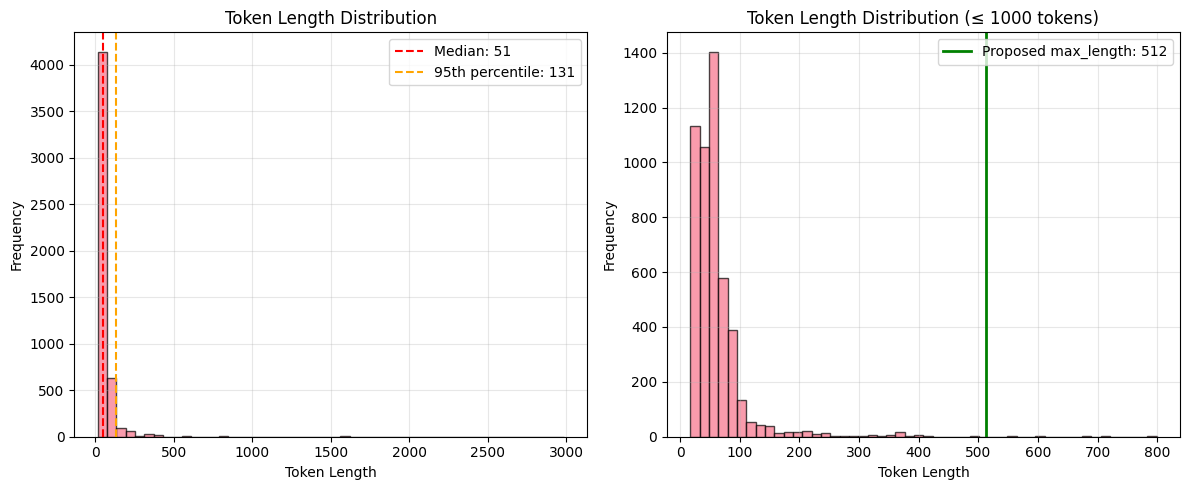


📐 Using MAX_LENGTH = 512
This will cover 99.5% of functions without truncation


In [6]:
# Analyze token lengths to determine optimal max_length
print("📏 Analyzing token lengths...")

# Sample a subset for analysis (for speed)
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

token_lengths = []
for code in tqdm(sample_df['code'], desc="Tokenizing sample"):
    try:
        tokens = tokenizer.encode(code, add_special_tokens=True)
        token_lengths.append(len(tokens))
    except:
        # Skip problematic codes
        token_lengths.append(0)

token_lengths = np.array(token_lengths)

print(f"\nToken length statistics (sample of {sample_size} functions):")
print(f"Mean: {token_lengths.mean():.1f}")
print(f"Median: {np.median(token_lengths):.1f}")
print(f"95th percentile: {np.percentile(token_lengths, 95):.1f}")
print(f"99th percentile: {np.percentile(token_lengths, 99):.1f}")
print(f"Max: {token_lengths.max()}")

# Plot token length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.median(token_lengths), color='red', linestyle='--', label=f'Median: {np.median(token_lengths):.0f}')
plt.axvline(np.percentile(token_lengths, 95), color='orange', linestyle='--', label=f'95th percentile: {np.percentile(token_lengths, 95):.0f}')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Zoom in on reasonable range
reasonable_lengths = token_lengths[token_lengths <= 1000]
plt.hist(reasonable_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(512, color='green', linestyle='-', linewidth=2, label='Proposed max_length: 512')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution (≤ 1000 tokens)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal max_length
MAX_LENGTH = 512
coverage = (token_lengths <= MAX_LENGTH).mean()
print(f"\n📐 Using MAX_LENGTH = {MAX_LENGTH}")
print(f"This will cover {coverage:.1%} of functions without truncation")

## Create Vulnerability Detection Dataset

In [7]:
class VulnerabilityDataset(Dataset):
    """
    PyTorch Dataset for Smart Contract Vulnerability Detection
    """
    
    def __init__(self, dataframe, tokenizer, max_length=512, label_type='binary'):
        """
        Initialize the dataset.
        
        Args:
            dataframe: pandas DataFrame with function data
            tokenizer: HuggingFace tokenizer
            max_length: Maximum sequence length for tokenization
            label_type: 'binary' for binary classification, 'multiclass' for category classification
        """
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_type = label_type
        
        # Prepare labels
        if label_type == 'binary':
            self.labels = self.data['is_vulnerable'].astype(int).values
            self.num_classes = 2
        elif label_type == 'multiclass':
            # Encode vulnerability categories
            self.label_encoder = LabelEncoder()
            # Create combined labels: safe (0) + vulnerability categories (1, 2, ...)
            category_labels = self.data['vulnerability_category'].copy()
            category_labels[~self.data['is_vulnerable']] = 'SAFE'
            self.labels = self.label_encoder.fit_transform(category_labels)
            self.num_classes = len(self.label_encoder.classes_)
            print(f"Label classes: {self.label_encoder.classes_}")
        
        print(f"Dataset initialized with {len(self.data)} samples")
        print(f"Label type: {label_type}")
        print(f"Number of classes: {self.num_classes}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Returns:
            dict with 'input_ids', 'attention_mask', 'labels', and metadata
        """
        # Get function code and label
        code = str(self.data.iloc[idx]['code'])
        label = self.labels[idx]
        
        # Tokenize the code
        encoding = self.tokenizer(
            code,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long),
            'function_name': self.data.iloc[idx]['function_name'],
            'vulnerability_category': self.data.iloc[idx]['vulnerability_category'],
            'code_length': self.data.iloc[idx]['code_length']
        }

# Create dataset instances
print("🏗️ Creating datasets...")

# Binary classification dataset
binary_dataset = VulnerabilityDataset(
    dataframe=df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

print("\n" + "="*50)

# Multi-class classification dataset
multiclass_dataset = VulnerabilityDataset(
    dataframe=df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='multiclass'
)

🏗️ Creating datasets...
Dataset initialized with 16720 samples
Label type: binary
Number of classes: 2

Label classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']
Dataset initialized with 16720 samples
Label type: multiclass
Number of classes: 8


## Test Dataset and Data Loading

In [8]:
# Test the dataset
print("🧪 Testing dataset functionality...")

# Test binary dataset
sample_binary = binary_dataset[0]
print(f"Binary dataset sample:")
print(f"  Input IDs shape: {sample_binary['input_ids'].shape}")
print(f"  Attention mask shape: {sample_binary['attention_mask'].shape}")
print(f"  Label: {sample_binary['labels'].item()} ({type(sample_binary['labels'].item())})")
print(f"  Function name: {sample_binary['function_name']}")
print(f"  Vulnerability category: {sample_binary['vulnerability_category']}")

print(f"\nMulticlass dataset sample:")
sample_multiclass = multiclass_dataset[0]
print(f"  Label: {sample_multiclass['labels'].item()} (class: {multiclass_dataset.label_encoder.classes_[sample_multiclass['labels'].item()]})")

# Test data loader with collate function
def collate_fn(batch):
    """
    Custom collate function to batch the data properly.
    """
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Test data loader
test_loader = DataLoader(
    binary_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn
)

# Get one batch
test_batch = next(iter(test_loader))
print(f"\nTest batch shapes:")
print(f"  Input IDs: {test_batch['input_ids'].shape}")
print(f"  Attention mask: {test_batch['attention_mask'].shape}")
print(f"  Labels: {test_batch['labels'].shape}")
print(f"  Labels: {test_batch['labels'].tolist()}")

print("\n✅ Dataset and DataLoader working correctly!")

🧪 Testing dataset functionality...
Binary dataset sample:
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Label: 1 (<class 'int'>)
  Function name: play_TOD33
  Vulnerability category: TOD

Multiclass dataset sample:
  Label: 3 (class: TOD)

Test batch shapes:
  Input IDs: torch.Size([4, 512])
  Attention mask: torch.Size([4, 512])
  Labels: torch.Size([4])
  Labels: [0, 0, 0, 0]

✅ Dataset and DataLoader working correctly!


## Create Train/Validation/Test Splits

In [9]:
# Create stratified train/validation/test splits
print("📊 Creating train/validation/test splits...")

# First, split into train+val and test (80% train+val, 20% test)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['vulnerability_category'],  # Stratify by vulnerability category
    random_state=42
)

# Then split train+val into train and val (80% train, 20% val of the remaining)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
    stratify=train_val_df['vulnerability_category'],
    random_state=42
)

print(f"Dataset splits:")
print(f"  Train: {len(train_df):,} samples ({len(train_df)/len(df):.1%})")
print(f"  Validation: {len(val_df):,} samples ({len(val_df)/len(df):.1%})")
print(f"  Test: {len(test_df):,} samples ({len(test_df)/len(df):.1%})")

# Check class distribution in each split
print(f"\nClass distribution:")
splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

for split_name, split_df in splits.items():
    vuln_rate = split_df['is_vulnerable'].mean()
    print(f"  {split_name}: {vuln_rate:.1%} vulnerable")

# Save the splits
print(f"\n💾 Saving dataset splits...")
train_df.to_csv('../data/processed/train_functions.csv', index=False)
val_df.to_csv('../data/processed/validation_functions.csv', index=False)
test_df.to_csv('../data/processed/test_functions.csv', index=False)

print(f"✅ Splits saved to ../data/processed/")

📊 Creating train/validation/test splits...
Dataset splits:
  Train: 10,032 samples (60.0%)
  Validation: 3,344 samples (20.0%)
  Test: 3,344 samples (20.0%)

Class distribution:
  Train: 5.9% vulnerable
  Validation: 4.9% vulnerable
  Test: 6.3% vulnerable

💾 Saving dataset splits...
✅ Splits saved to ../data/processed/
✅ Splits saved to ../data/processed/


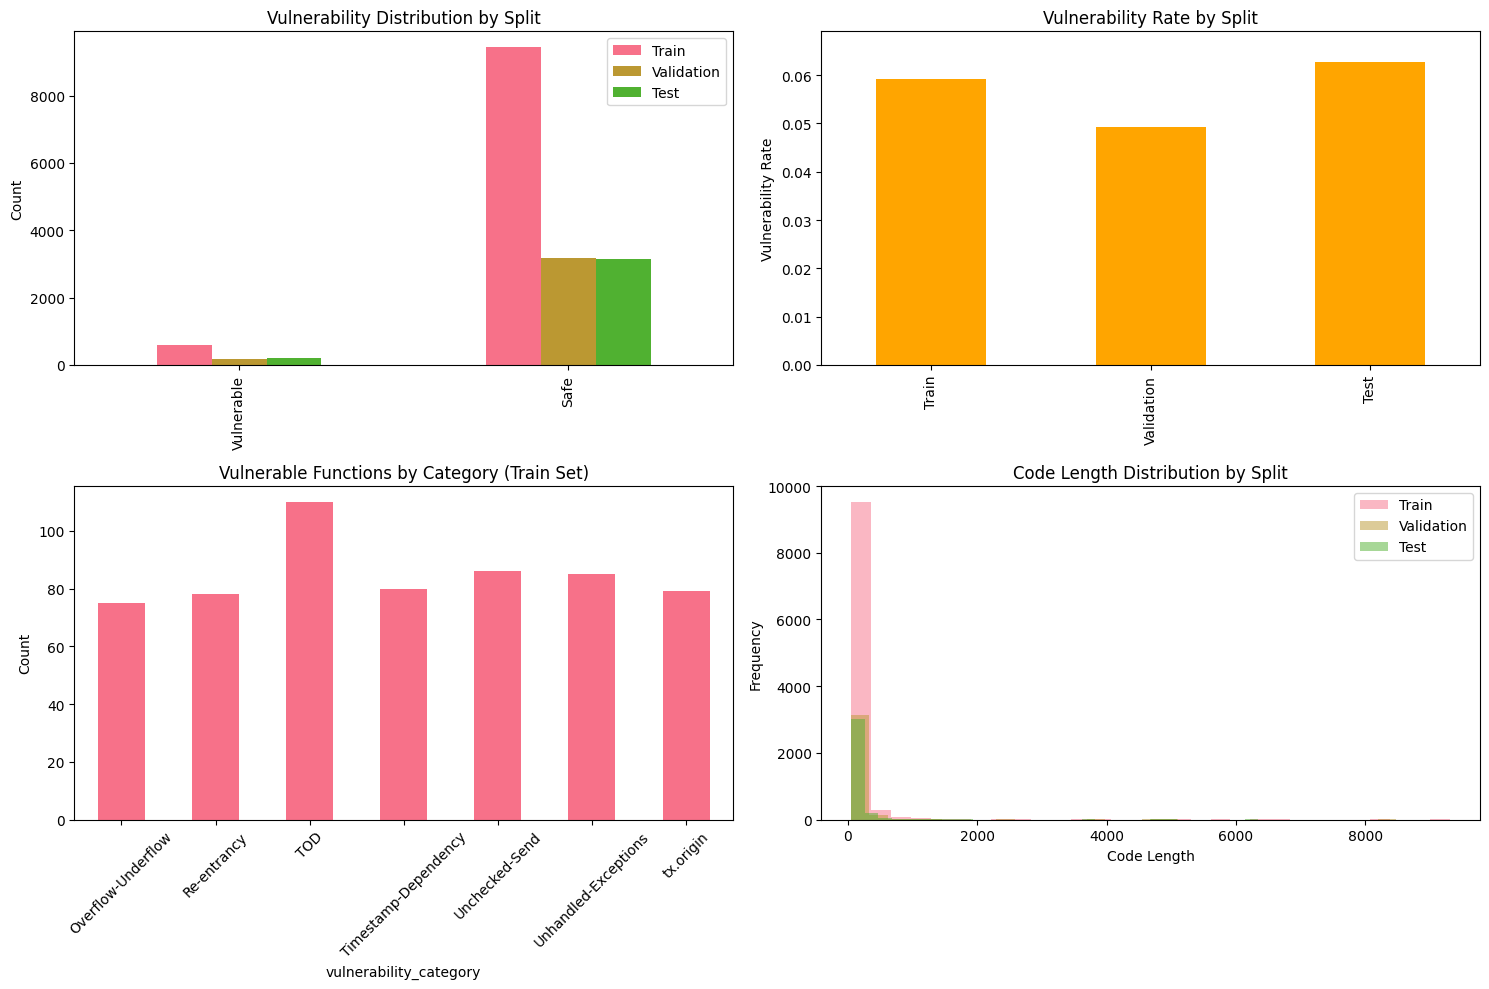

In [10]:
# Visualize split distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall vulnerability distribution by split
split_stats = pd.DataFrame({
    'Train': [train_df['is_vulnerable'].sum(), (~train_df['is_vulnerable']).sum()],
    'Validation': [val_df['is_vulnerable'].sum(), (~val_df['is_vulnerable']).sum()],
    'Test': [test_df['is_vulnerable'].sum(), (~test_df['is_vulnerable']).sum()]
}, index=['Vulnerable', 'Safe'])

split_stats.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Vulnerability Distribution by Split')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()

# Vulnerability rates by split
vuln_rates = pd.Series({
    'Train': train_df['is_vulnerable'].mean(),
    'Validation': val_df['is_vulnerable'].mean(),
    'Test': test_df['is_vulnerable'].mean()
})

vuln_rates.plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Vulnerability Rate by Split')
axes[0,1].set_ylabel('Vulnerability Rate')
axes[0,1].set_ylim(0, vuln_rates.max() * 1.1)

# Category distribution in train set
train_cat_dist = train_df.groupby('vulnerability_category')['is_vulnerable'].sum()
train_cat_dist.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Vulnerable Functions by Category (Train Set)')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Function length distribution by split
for split_name, split_df in splits.items():
    axes[1,1].hist(split_df['code_length'], bins=30, alpha=0.5, label=split_name)

axes[1,1].set_title('Code Length Distribution by Split')
axes[1,1].set_xlabel('Code Length')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Create Dataset Objects for Each Split

In [11]:
# Create dataset objects for each split
print("🏗️ Creating dataset objects for each split...")

# Binary classification datasets
train_dataset_binary = VulnerabilityDataset(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

val_dataset_binary = VulnerabilityDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

test_dataset_binary = VulnerabilityDataset(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

print("\n" + "="*50)

# Multi-class classification datasets
train_dataset_multiclass = VulnerabilityDataset(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='multiclass'
)

val_dataset_multiclass = VulnerabilityDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='multiclass'
)

test_dataset_multiclass = VulnerabilityDataset(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='multiclass'
)

print(f"\n✅ All dataset objects created successfully!")
print(f"Binary datasets: Train={len(train_dataset_binary)}, Val={len(val_dataset_binary)}, Test={len(test_dataset_binary)}")
print(f"Multiclass datasets: Train={len(train_dataset_multiclass)}, Val={len(val_dataset_multiclass)}, Test={len(test_dataset_multiclass)}")

🏗️ Creating dataset objects for each split...
Dataset initialized with 10032 samples
Label type: binary
Number of classes: 2
Dataset initialized with 3344 samples
Label type: binary
Number of classes: 2
Dataset initialized with 3344 samples
Label type: binary
Number of classes: 2

Label classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']
Dataset initialized with 10032 samples
Label type: multiclass
Number of classes: 8
Label classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']
Dataset initialized with 3344 samples
Label type: multiclass
Number of classes: 8
Label classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']
Dataset initialized with 3344 samples
Label type: multiclass
Number of classes: 8

✅ All dataset objects created successfully!
Bin

## Create Data Loaders

In [12]:
# Create data loaders for training
print("📦 Creating data loaders...")

BATCH_SIZE = 16  # Adjust based on your GPU memory
NUM_WORKERS = 2  # Adjust based on your CPU cores

# Binary classification data loaders
train_loader_binary = DataLoader(
    train_dataset_binary,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_loader_binary = DataLoader(
    val_dataset_binary,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

test_loader_binary = DataLoader(
    test_dataset_binary,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

# Multi-class classification data loaders
train_loader_multiclass = DataLoader(
    train_dataset_multiclass,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_loader_multiclass = DataLoader(
    val_dataset_multiclass,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

test_loader_multiclass = DataLoader(
    test_dataset_multiclass,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

print(f"Data loaders created with batch_size={BATCH_SIZE}")
print(f"Binary loaders: Train={len(train_loader_binary)} batches, Val={len(val_loader_binary)} batches, Test={len(test_loader_binary)} batches")
print(f"Multiclass loaders: Train={len(train_loader_multiclass)} batches, Val={len(val_loader_multiclass)} batches, Test={len(test_loader_multiclass)} batches")

📦 Creating data loaders...
Data loaders created with batch_size=16
Binary loaders: Train=627 batches, Val=209 batches, Test=209 batches
Multiclass loaders: Train=627 batches, Val=209 batches, Test=209 batches


## Test Data Loaders

In [13]:
# Test data loaders
print("🧪 Testing data loaders...")

# Test binary loader
print("Binary classification loader:")
batch_binary = next(iter(train_loader_binary))
print(f"  Batch shapes: input_ids={batch_binary['input_ids'].shape}, attention_mask={batch_binary['attention_mask'].shape}, labels={batch_binary['labels'].shape}")
print(f"  Label distribution in batch: {torch.bincount(batch_binary['labels'])}")
print(f"  Sample labels: {batch_binary['labels'].tolist()}")

# Test multiclass loader
print(f"\nMulticlass classification loader:")
batch_multiclass = next(iter(train_loader_multiclass))
print(f"  Batch shapes: input_ids={batch_multiclass['input_ids'].shape}, attention_mask={batch_multiclass['attention_mask'].shape}, labels={batch_multiclass['labels'].shape}")
print(f"  Label distribution in batch: {torch.bincount(batch_multiclass['labels'])}")
print(f"  Sample labels: {batch_multiclass['labels'].tolist()}")
print(f"  Label classes: {[train_dataset_multiclass.label_encoder.classes_[i] for i in batch_multiclass['labels'].tolist()]}")

print(f"\n✅ All data loaders working correctly!")

🧪 Testing data loaders...
Binary classification loader:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Batch shapes: input_ids=torch.Size([16, 512]), attention_mask=torch.Size([16, 512]), labels=torch.Size([16])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Label distribution in batch: tensor([16])
  Sample labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Multiclass classification loader:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Batch shapes: input_ids=torch.Size([16, 512]), attention_mask=torch.Size([16, 512]), labels=torch.Size([16])
  Label distribution in batch: tensor([ 0,  0, 13,  2,  0,  0,  0,  1])
  Sample labels: [3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2]
  Label classes: ['TOD', 'SAFE', 'SAFE', 'TOD', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'SAFE', 'tx.origin', 'SAFE', 'SAFE']

✅ All data loaders working correctly!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Create and Save Small Subset for Quick Testing

In [14]:
# Create a small subset for quick model testing and development
print("📦 Creating small subset for quick testing...")

SUBSET_SIZE = 1000  # Small subset for quick experiments

# Sample from train set maintaining class balance
train_subset = train_df.groupby('is_vulnerable').apply(
    lambda x: x.sample(n=min(SUBSET_SIZE//2, len(x)), random_state=42)
).reset_index(drop=True)

val_subset = val_df.groupby('is_vulnerable').apply(
    lambda x: x.sample(n=min(200, len(x)), random_state=42)
).reset_index(drop=True)

print(f"Subset sizes:")
print(f"  Train subset: {len(train_subset)} samples")
print(f"  Validation subset: {len(val_subset)} samples")

# Create dataset objects for subsets
train_subset_dataset = VulnerabilityDataset(
    dataframe=train_subset,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

val_subset_dataset = VulnerabilityDataset(
    dataframe=val_subset,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    label_type='binary'
)

# Create subset data loaders
train_subset_loader = DataLoader(
    train_subset_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_subset_loader = DataLoader(
    val_subset_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Subset loaders: Train={len(train_subset_loader)} batches, Val={len(val_subset_loader)} batches")
print(f"✅ Subset datasets created for quick testing")

📦 Creating small subset for quick testing...
Subset sizes:
  Train subset: 1000 samples
  Validation subset: 365 samples
Dataset initialized with 1000 samples
Label type: binary
Number of classes: 2
Dataset initialized with 365 samples
Label type: binary
Number of classes: 2
Subset loaders: Train=63 batches, Val=23 batches
✅ Subset datasets created for quick testing
Subset sizes:
  Train subset: 1000 samples
  Validation subset: 365 samples
Dataset initialized with 1000 samples
Label type: binary
Number of classes: 2
Dataset initialized with 365 samples
Label type: binary
Number of classes: 2
Subset loaders: Train=63 batches, Val=23 batches
✅ Subset datasets created for quick testing


## Save Processed Datasets

In [15]:
# Save processed datasets and configurations
print("💾 Saving processed datasets and configurations...")

# Create directory for processed data
processed_dir = Path('../data/processed')
processed_dir.mkdir(exist_ok=True)

# Save dataset configuration
dataset_config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': BATCH_SIZE,
    'num_classes_binary': 2,
    'num_classes_multiclass': train_dataset_multiclass.num_classes,
    'label_encoder_classes': train_dataset_multiclass.label_encoder.classes_.tolist(),
    'dataset_sizes': {
        'train': len(train_dataset_binary),
        'validation': len(val_dataset_binary),
        'test': len(test_dataset_binary)
    },
    'class_distribution': {
        'train_vulnerable_rate': float(train_df['is_vulnerable'].mean()),
        'val_vulnerable_rate': float(val_df['is_vulnerable'].mean()),
        'test_vulnerable_rate': float(test_df['is_vulnerable'].mean())
    }
}

with open('../data/processed/dataset_config.json', 'w') as f:
    json.dump(dataset_config, f, indent=2)

# Save label encoder for multiclass
with open('../data/processed/label_encoder.pkl', 'wb') as f:
    pickle.dump(train_dataset_multiclass.label_encoder, f)

# Save subset datasets for quick testing
subset_datasets = {
    'train_subset_loader': train_subset_loader,
    'val_subset_loader': val_subset_loader,
    'train_subset_dataset': train_subset_dataset,
    'val_subset_dataset': val_subset_dataset
}

torch.save(subset_datasets, '../data/processed/subset_datasets.pt')

print(f"✅ Saved:")
print(f"  - Dataset configuration: ../data/processed/dataset_config.json")
print(f"  - Label encoder: ../data/processed/label_encoder.pkl")
print(f"  - Subset datasets: ../data/processed/subset_datasets.pt")
print(f"  - CSV splits: train/validation/test_functions.csv")

💾 Saving processed datasets and configurations...
✅ Saved:
  - Dataset configuration: ../data/processed/dataset_config.json
  - Label encoder: ../data/processed/label_encoder.pkl
  - Subset datasets: ../data/processed/subset_datasets.pt
  - CSV splits: train/validation/test_functions.csv
✅ Saved:
  - Dataset configuration: ../data/processed/dataset_config.json
  - Label encoder: ../data/processed/label_encoder.pkl
  - Subset datasets: ../data/processed/subset_datasets.pt
  - CSV splits: train/validation/test_functions.csv


## Summary and Next Steps

In [16]:
# Print final summary
print("🎉 TOKENIZATION AND DATASET CREATION COMPLETE!")
print("=" * 50)

print(f"\n📊 Dataset Summary:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total functions: {len(df):,}")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df):.1%})")
print(f"  Validation: {len(val_df):,} ({len(val_df)/len(df):.1%})")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df):.1%})")

print(f"\n🏷️ Classification Tasks:")
print(f"  Binary: 2 classes (vulnerable vs safe)")
print(f"  Multiclass: {train_dataset_multiclass.num_classes} classes (safe + {train_dataset_multiclass.num_classes-1} vulnerability types)")
print(f"  Classes: {train_dataset_multiclass.label_encoder.classes_}")

print(f"\n📦 Data Loaders Created:")
print(f"  Binary classification: train, validation, test")
print(f"  Multiclass classification: train, validation, test")
print(f"  Quick testing subset: train_subset, val_subset")

print(f"\n💾 Files Saved:")
print(f"  - ../data/processed/dataset_config.json")
print(f"  - ../data/processed/label_encoder.pkl")
print(f"  - ../data/processed/subset_datasets.pt")
print(f"  - ../data/processed/train_functions.csv")
print(f"  - ../data/processed/validation_functions.csv")
print(f"  - ../data/processed/test_functions.csv")

print(f"\n🚀 Ready for Model Training!")
print(f"Next step: notebook 04_train_codebert_baseline.ipynb")

print(f"\n💡 Usage Example:")
print(f"```python")
print(f"# Load the datasets")
print(f"subset_data = torch.load('../data/processed/subset_datasets.pt')")
print(f"train_loader = subset_data['train_subset_loader']")
print(f"val_loader = subset_data['val_subset_loader']")
print(f"")
print(f"# For full dataset, recreate loaders from CSV files")
print(f"train_df = pd.read_csv('../data/processed/train_functions.csv')")
print(f"# ... create dataset and loader as shown above")
print(f"```")

🎉 TOKENIZATION AND DATASET CREATION COMPLETE!

📊 Dataset Summary:
  Model: microsoft/codebert-base
  Max sequence length: 512
  Batch size: 16
  Total functions: 16,720
  Train: 10,032 (60.0%)
  Validation: 3,344 (20.0%)
  Test: 3,344 (20.0%)

🏷️ Classification Tasks:
  Binary: 2 classes (vulnerable vs safe)
  Multiclass: 8 classes (safe + 7 vulnerability types)
  Classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']

📦 Data Loaders Created:
  Binary classification: train, validation, test
  Multiclass classification: train, validation, test
  Quick testing subset: train_subset, val_subset

💾 Files Saved:
  - ../data/processed/dataset_config.json
  - ../data/processed/label_encoder.pkl
  - ../data/processed/subset_datasets.pt
  - ../data/processed/train_functions.csv
  - ../data/processed/validation_functions.csv
  - ../data/processed/test_functions.csv

🚀 Ready for Model Training!
Next step: notebook 04_t